## Initial Setup and Libraries

In [ ]:
# All libraries needed to run the program
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
import pickle
from sklearn.feature_selection import RFE
import zipfile

## Preoprocessing and Data Cleaning

In [ ]:
# Reading in dataset 
flight_data = pd.read_csv("flight_data.zip")

In [ ]:
# Dropping unnecessary columns
flight_data.drop(columns=['legId', 'searchDate', 'fareBasisCode', 'elapsedDays',
                          'segmentsDepartureTimeEpochSeconds', 'segmentsDepartureTimeRaw',
                          'segmentsArrivalTimeEpochSeconds', 'segmentsArrivalTimeRaw',
                          'segmentsArrivalAirportCode', 'segmentsDepartureAirportCode', 
                          'segmentsAirlineCode', 'totalFare'], inplace=True, errors='ignore')

# Noting rows that have missing values 
flight_data.isnull().sum()

flightDate                          0
startingAirport                     0
destinationAirport                  0
travelDuration                      0
isBasicEconomy                      0
isRefundable                        0
isNonStop                           0
baseFare                            0
seatsRemaining                      0
totalTravelDistance             61860
segmentsAirlineName                 0
segmentsEquipmentDescription    18754
segmentsDurationInSeconds           0
segmentsDistance                 7724
segmentsCabinCode                   0
dtype: int64

In [ ]:
# Cleaning 'segmentsDistance feature by extracting the first value from pipe-separated variables, 
# replacing blanks cells, converting to numeric, and filling missing values
flight_data['segmentsDistance'] = flight_data['segmentsDistance'].str.split(r'\|\|').str[0]
flight_data['segmentsDistance'] = flight_data['segmentsDistance'].replace(['', 'None'], np.nan)
flight_data['segmentsDistance'] = pd.to_numeric(flight_data['segmentsDistance'], errors='coerce')
flight_data['segmentsDistance'] = flight_data['segmentsDistance'].fillna(flight_data['segmentsDistance'].median())

# Extracting first airline from pipe-separated variables for 'segmentsAirlineName'
flight_data['segmentsAirlineName'] = flight_data['segmentsAirlineName'].str.split(r'\|\|').str[0]

# Dropping missing rows for 'segmentsEquipmentDescription' and resetting index
flight_data = flight_data[flight_data['segmentsEquipmentDescription'].notnull()].reset_index(drop=True)

# Converting 'totalTravelDistance' to numeric and filling missing values with the median
flight_data['totalTravelDistance'] = pd.to_numeric(flight_data['totalTravelDistance'], errors='coerce')
flight_data['totalTravelDistance'] = flight_data['totalTravelDistance'].fillna(flight_data['totalTravelDistance'].median())

# Checking again for missing values
flight_data.isnull().sum()

flightDate                      0
startingAirport                 0
destinationAirport              0
travelDuration                  0
isBasicEconomy                  0
isRefundable                    0
isNonStop                       0
baseFare                        0
seatsRemaining                  0
totalTravelDistance             0
segmentsAirlineName             0
segmentsEquipmentDescription    0
segmentsDurationInSeconds       0
segmentsDistance                0
segmentsCabinCode               0
dtype: int64

In [ ]:
# Keeping rows where 'travelDuration' is not missing
# Keeping rows where 'travelDuration' starts with 'PT'
flight_data = flight_data[flight_data['travelDuration'].notna()]
flight_data = flight_data[flight_data['travelDuration'].str.startswith('PT')]

# Keeping rows where 'segmentsDurationInSeconds' is not missing 
flight_data = flight_data[flight_data['segmentsDurationInSeconds'].notna()]

In [ ]:
# Defining function to convert 'travelDuration' to total minutes
def conversion(duration):
    try:
        if pd.isna(duration): return None
        match = re.match(r'PT(?:(\d+)H)?(?:(\d+)M)?', duration)
        hours = int(match.group(1)) if match.group(1) else 0
        minutes = int(match.group(2)) if match.group(2) else 0
        return hours * 60 + minutes
    except:
        return None

# Applying function to convert 'travelDuration' column into total minutes for each cell 
flight_data['travelDuration'] = flight_data['travelDuration'].apply(conversion)

# Defining function to sum duration
def summation(value):
    try:
        if pd.isna(value): return None
        return sum(int(i) for i in value.split('||') if i.isdigit())
    except:
        return None

# Applying summation function to 'segmentsDurationInSeconds' and converting to numeric
flight_data['segmentsDurationInSeconds'] = flight_data['segmentsDurationInSeconds'].apply(summation)
flight_data['segmentsDurationInSeconds'] = pd.to_numeric(flight_data['segmentsDurationInSeconds'], errors='coerce')



In [ ]:
# Removing rows where there are pipe-separated variables, leading and trailing pipes, and stripping extra whitespace
flight_data = flight_data[~flight_data['segmentsEquipmentDescription'].str.fullmatch(r'\|+', na=False)]

flight_data['segmentsEquipmentDescription'] = (flight_data['segmentsEquipmentDescription']
    .str.replace(r'^\|+', '', regex=True)  
    .str.replace(r'\|+$', '', regex=True)  
    .str.strip() 
)


In [ ]:
# Keeping only the first value from pipe-separated variables in 'segmentsCabinCode' column and stripping extra spaces
flight_data['segmentsCabinCode'] = (flight_data['segmentsCabinCode'].str.split(r'\|\|').str[0].str.strip())

In [ ]:
# Converting 'flightDate' to ordinal format and renaming the column to 'flightDateOrdinal'
flight_data['flightDate'] = pd.to_datetime(flight_data['flightDate']).map(lambda x: x.toordinal())
flight_data.rename(columns = {'flightDate': 'flightDateOrdinal'}, inplace = True)

In [ ]:
# Converting preprocessing dataset to new csv zip file
flight_data.to_csv('flight_data_preprocessed.csv.zip', index=False, compression='zip')

## Start

In [ ]:
# Reading newly created preprocessed dataset 
flight_data_cleaned = pd.read_csv("flight_data_preprocessed.csv.zip")

## Exploratory Data Analysis

In [ ]:
# Storing categorical variables from dataset
categorical = ['startingAirport', 'destinationAirport', 'segmentsAirlineName',
               'segmentsEquipmentDescription', 'segmentsCabinCode']


# One-Hot Encoding categorical variables for Linear Regression
onehot_encoding = pd.get_dummies(flight_data_cleaned, columns = categorical, drop_first = True)


# Label Encoding categorical variables for Random Forest and XGBoost
label = flight_data_cleaned.copy()
label_encoding = {}
for col in categorical:
    encode = LabelEncoder()
    label[col] = encode.fit_transform(label[col])
    label_encoding[col] = encode

<Axes: >

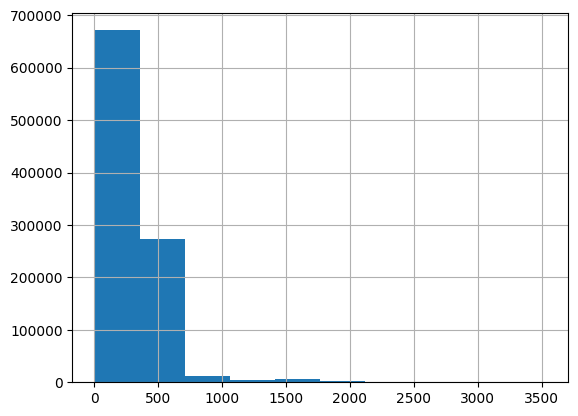

In [ ]:
# Visualizing histogram for 'baseFare'
flight_data_cleaned['baseFare'].hist()

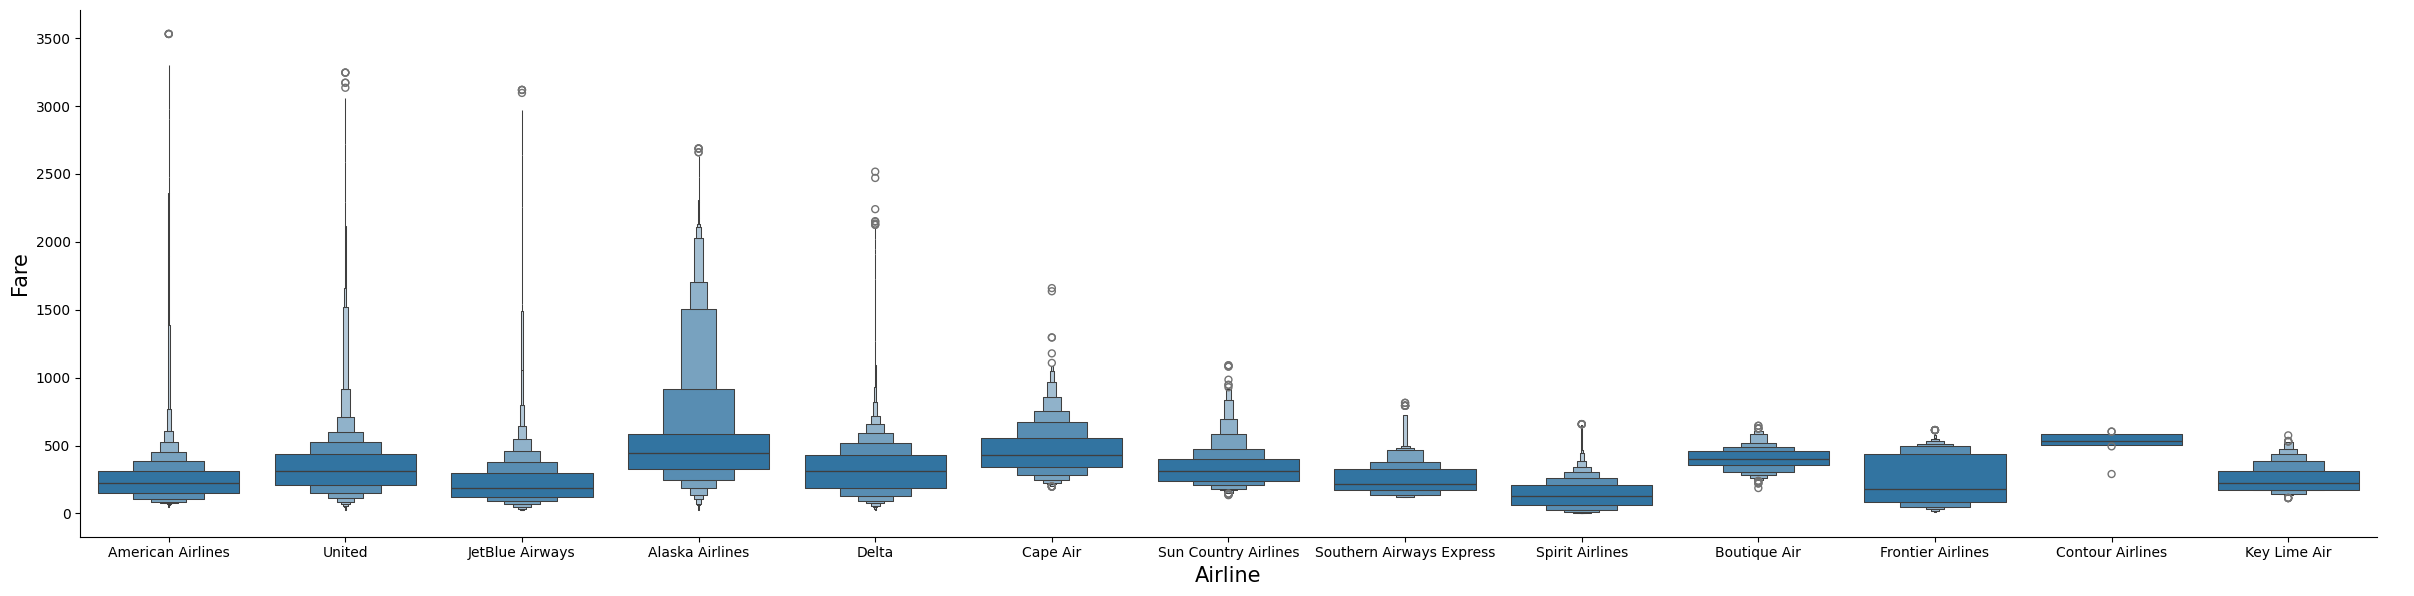

In [ ]:
# Plotting boxen plot to visualize distribution of 'baseFare' for each airline
sns.catplot(y = 'baseFare', x = 'segmentsAirlineName', data = 
            flight_data_cleaned.sort_values('baseFare', ascending=False), 
            kind = 'boxen', height = 6, aspect = 4)
plt.xlabel('Airline', size = 15)
plt.ylabel('Fare', size = 15)
plt.show()

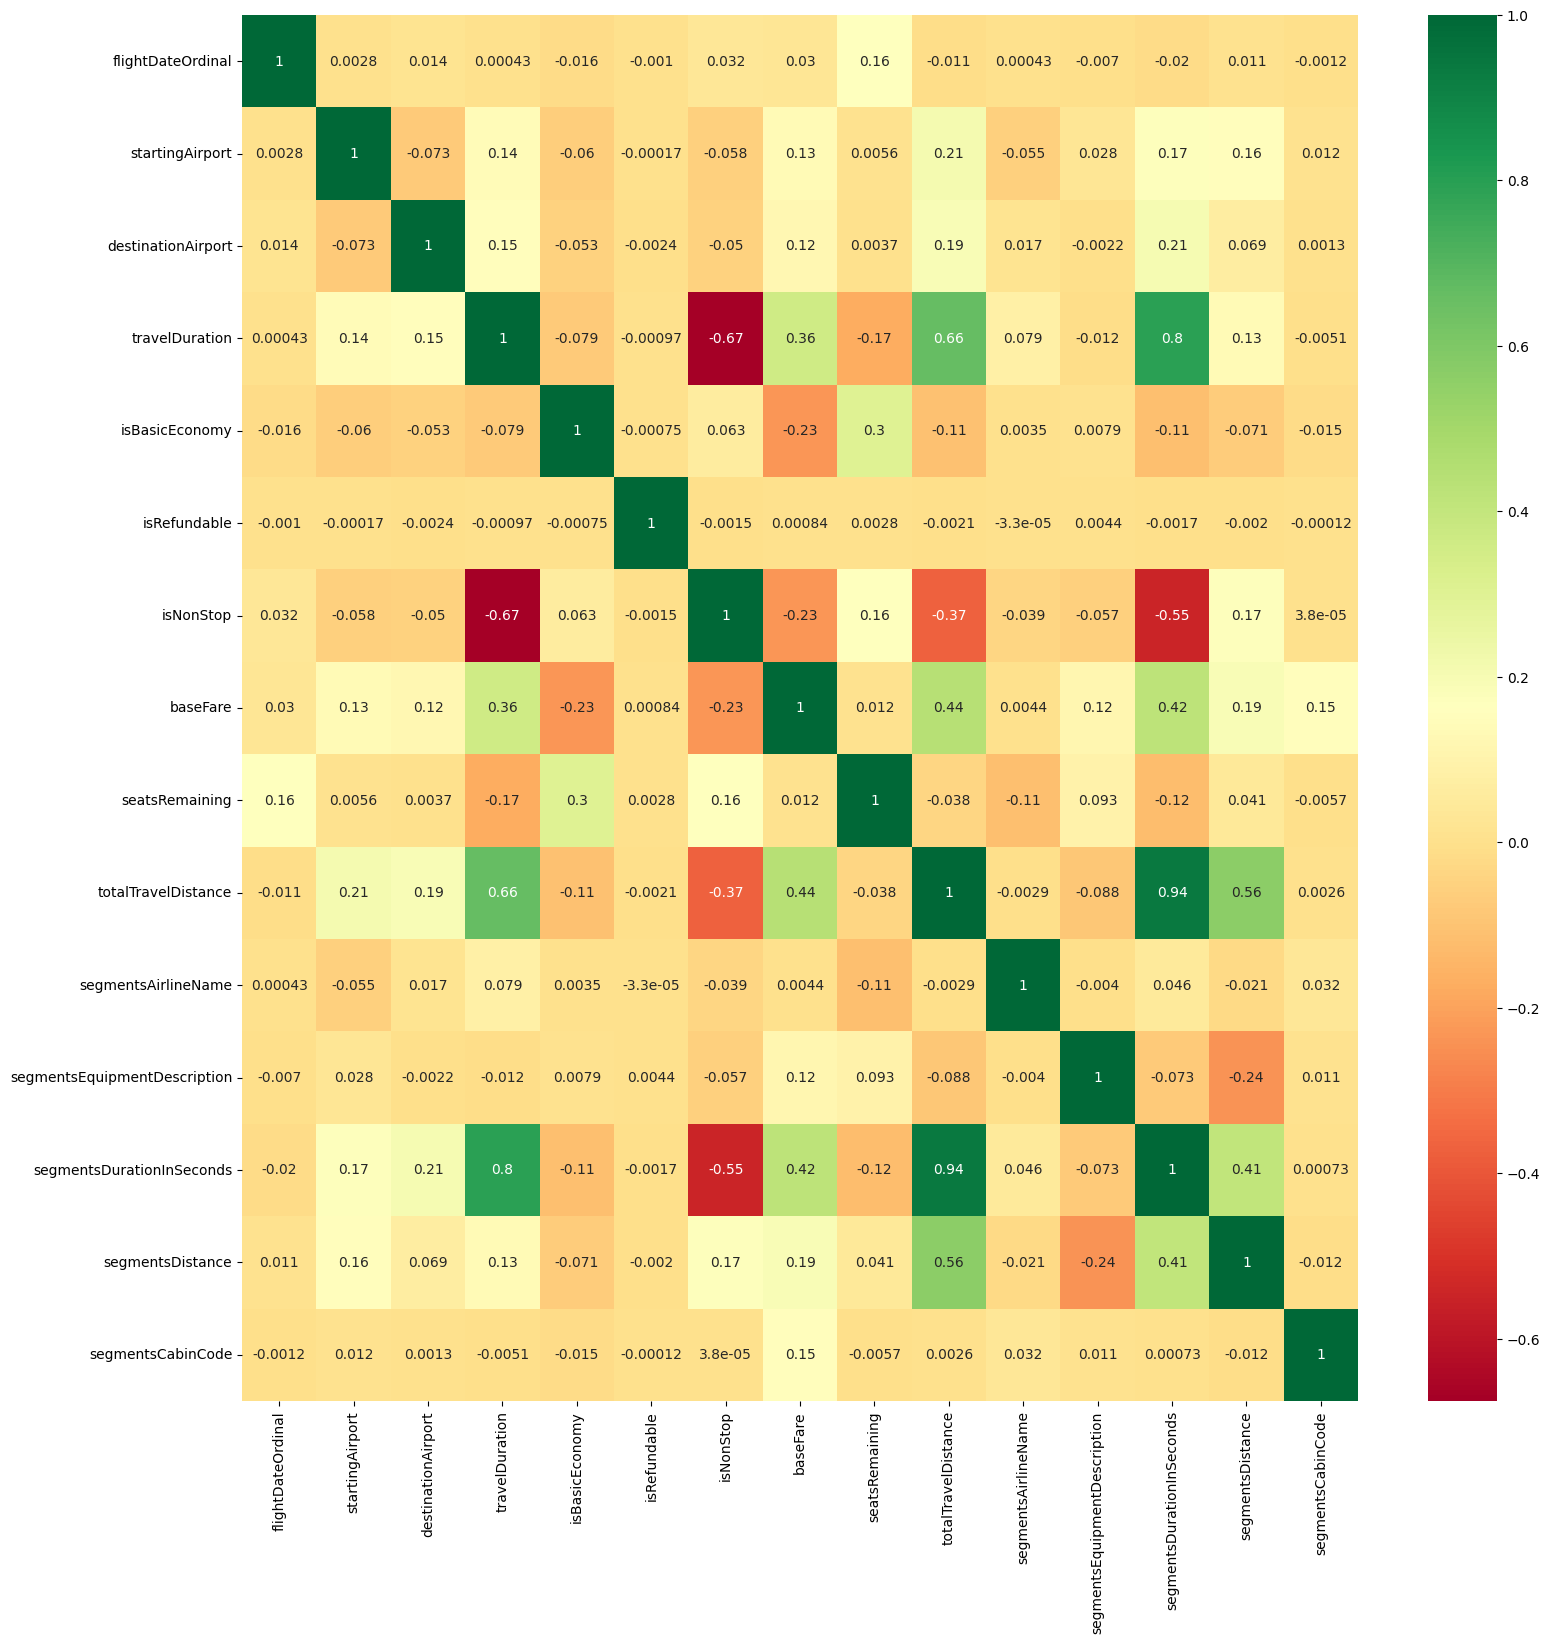

In [ ]:
# Plotting heatmap to visualize correlation between numeric features
plt.figure(figsize = (18, 18))
sns.heatmap(label.corr(), annot = True, cmap = 'RdYlGn')
plt.show()

In [ ]:
# Training ExtraTreesRegressor Model to identify important features
X = label.drop(columns = ['baseFare'])
y = label['baseFare']

model = ExtraTreesRegressor()
model.fit(X, y)

ExtraTreesRegressor()

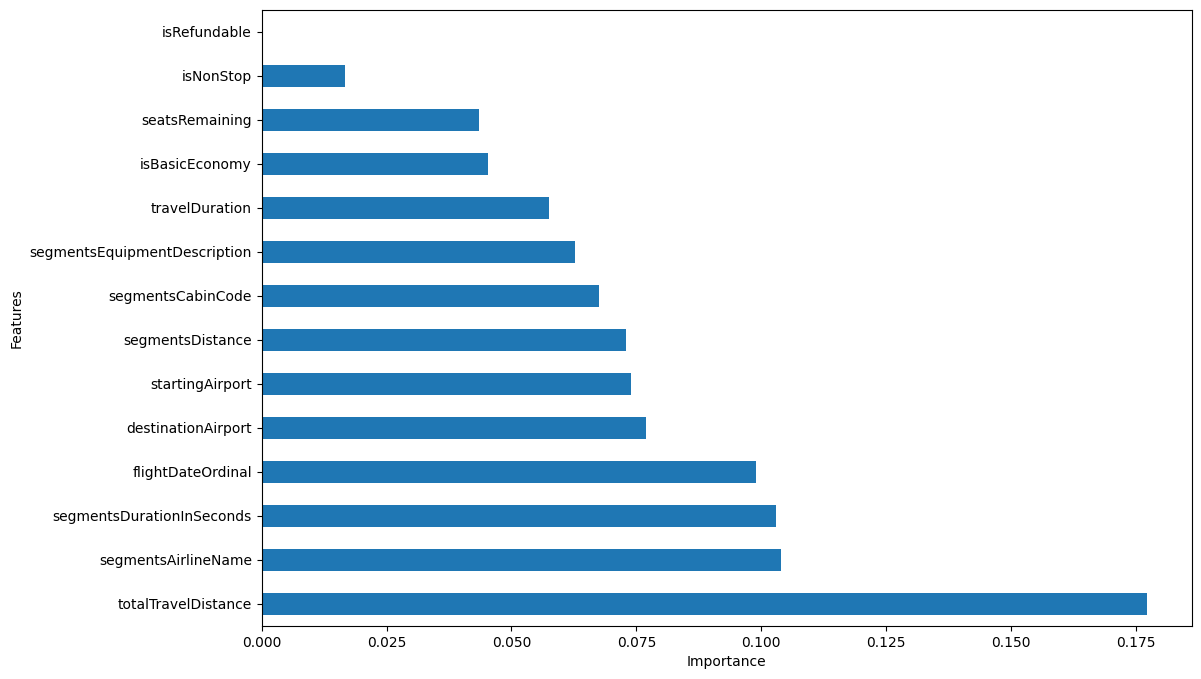

In [ ]:
# Plotting top 15 most important features based on the ExtraTreesRegressor Model
plt.figure(figsize = (12, 8))
feature_importance = pd.Series(model.feature_importances_, index = X.columns)
feature_importance.nlargest(15).plot(kind = 'barh')
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

## Model Setup

In [ ]:
# Specifying and storing important features based on analysis
"""
Important Features: 
- totalTravelDistance
- segmentsDurationInSeconds
- travelDuration
- flightDateOrdinal
- isBasicEconomy
- segmentsAirlineName
- startingAirport
- destinationAirport
- segmentsDistance
- segmentsCabinCode
"""

important_features = ['totalTravelDistance', 'segmentsDurationInSeconds', 'travelDuration',
                      'flightDateOrdinal', 'isBasicEconomy', 'segmentsAirlineName',
                      'startingAirport', 'destinationAirport', 'segmentsDistance',
                      'segmentsCabinCode']

In [ ]:
# Preparing feature sets and target variables for model training 
# Using one-hot encoded data for Linear Regression
# Using label encoded data for Random Forest and XGBoost
X_linear = onehot_encoding[[col for col in onehot_encoding.columns if any(f in col for f in important_features)]]
y_linear = onehot_encoding['baseFare']

X_tree = label[important_features]
y_tree = label['baseFare']

In [ ]:
# Performing Recursive Feature Elimination (RFE) with Random Forest to rank feature importance
# Double checking and enforcing important features
rfe = RFE(estimator=RandomForestRegressor(), n_features_to_select=10)
rfe.fit(X_tree, y_tree)
print(pd.Series(rfe.ranking_, index=X_tree.columns).sort_values())


totalTravelDistance          1
segmentsDurationInSeconds    1
travelDuration               1
flightDateOrdinal            1
isBasicEconomy               1
segmentsAirlineName          1
startingAirport              1
destinationAirport           1
segmentsDistance             1
segmentsCabinCode            1
dtype: int64


In [ ]:
# Splitting data into 70% for training and 30% for testing 
X_train_linear, X_test_linear, y_train_linear, y_test_linear = train_test_split(X_linear, y_linear, test_size = 0.3, random_state = 42)
X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(X_tree, y_tree, test_size = 0.3, random_state = 42)

## Multiple Linear Regression

In [ ]:
# Training Multiple Linear Regression Model and making predictions on test set
linear = LinearRegression()
linear.fit(X_train_linear, y_train_linear)
y_pred_linear = linear.predict(X_test_linear)

## Random Forest

In [ ]:
# Training Random Forest Model and making predictions on test set
randomForest = RandomForestRegressor(n_estimators = 100, random_state = 42, n_jobs = -1)
randomForest.fit(X_train_tree, y_train_tree)
y_pred_randomForest = randomForest.predict(X_test_tree)

## Gradient Boosting (XGBoosting)

In [ ]:
# Training XGBoost Model and making predictions on test set
xgb = XGBRegressor(n_estimators = 100, random_state = 42, n_jobs = -1)
xgb.fit(X_train_tree, y_train_tree)
y_pred_xgb = xgb.predict(X_test_tree)

## Model Performance

In [ ]:
# Printing evaluation metrics of each of the 3 trained model 
# MAE, RSME, and R²
print("Linear Regression")
print("MAE  :", (mean_absolute_error(y_test_linear, y_pred_linear)))
print("RMSE :", (root_mean_squared_error(y_test_linear, y_pred_linear)))
print("R²   :", r2_score(y_test_linear, y_pred_linear))

print("")

print("Random Forest")
print("MAE  :", (mean_absolute_error(y_test_tree, y_pred_randomForest)))
print("RMSE :", (root_mean_squared_error(y_test_tree, y_pred_randomForest)))
print("R²   :", r2_score(y_test_tree, y_pred_randomForest))

print("")

print("XGBoosting")
print("MAE  :", (mean_absolute_error(y_test_tree, y_pred_xgb)))
print("RMSE :", (root_mean_squared_error(y_test_tree, y_pred_xgb)))
print("R²   :", r2_score(y_test_tree, y_pred_xgb))

Linear Regression


NameError: name 'mean_absolute_error' is not defined

In [ ]:
# Defining function for custom accuaracy based on Mean Absolute Percentage Error (MAPE)
# Used to further evaluate models 
def accuracy(y_true, y_pred):
    errors = abs(y_true - y_pred)
    mape = 100 * np.mean(errors/y_true)
    accuracy = 100 - mape
    return accuracy


# Printing custom accuracy for each of the 3 trained models 
print("Linear Regression Accuracy: ", accuracy(y_test_linear, y_pred_linear))
print("Random Forest Accuracy: ", accuracy(y_test_tree, y_pred_randomForest))
print("XGBoosting Accuracy: ", accuracy(y_test_tree, y_pred_xgb))

Linear Regression Accuracy:  51.21215452059816
Random Forest Accuracy:  85.95943694298451
XGBoosting Accuracy:  69.96397663224829


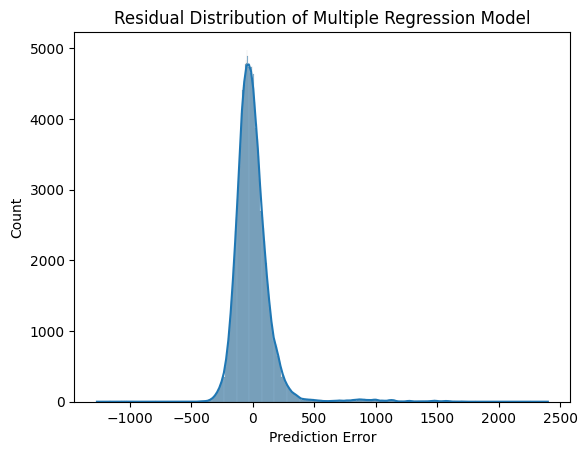

In [ ]:
# Plotting residual destribution for the Linear Regression Model 
sns.histplot(y_test_linear - y_pred_linear, kde=True)  
plt.title("Residual Distribution of Multiple Regression Model")
plt.xlabel("Prediction Error")
plt.show()


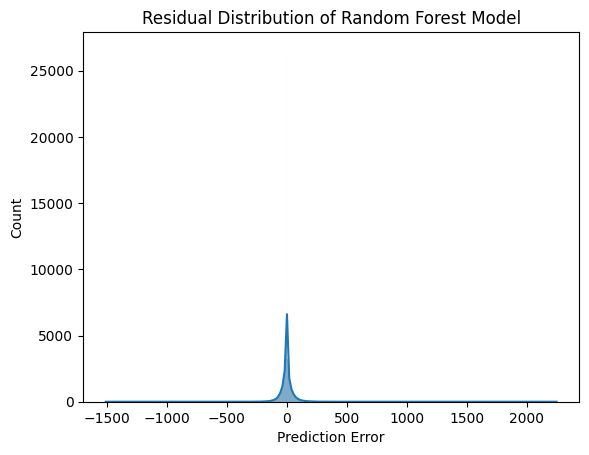

In [ ]:
# Plotting residual destribution for the Random Forest Model 
sns.histplot(y_test_tree - y_pred_randomForest, kde=True)  
plt.title("Residual Distribution of Random Forest Model")
plt.xlabel("Prediction Error")
plt.show()

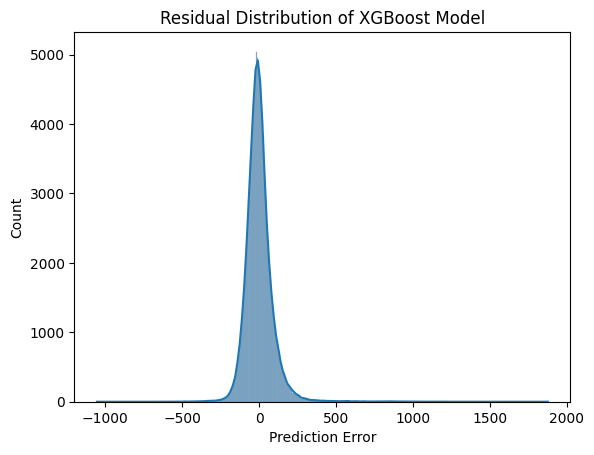

In [ ]:
# Plotting residual destribution for the XGBoost Model 
sns.histplot(y_test_tree - y_pred_xgb, kde=True)  
plt.title("Residual Distribution of XGBoost Model")
plt.xlabel("Prediction Error")
plt.show()

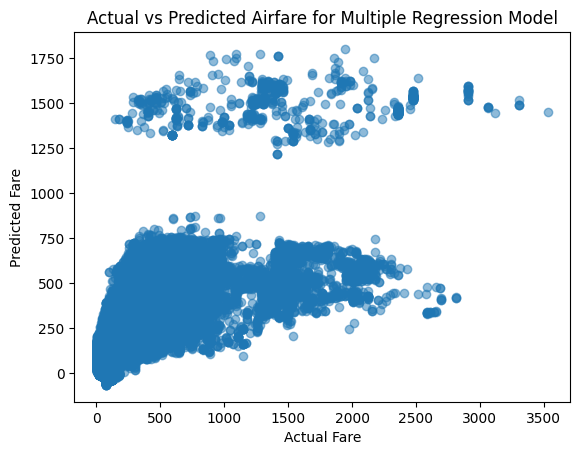

In [ ]:
# Plotting Actual vs Predicted airfares for the Linear Regression Model
plt.scatter(y_test_linear, y_pred_linear, alpha=0.5)
plt.xlabel("Actual Fare")
plt.ylabel("Predicted Fare")
plt.title("Actual vs Predicted Airfare for Multiple Regression Model")
plt.show()

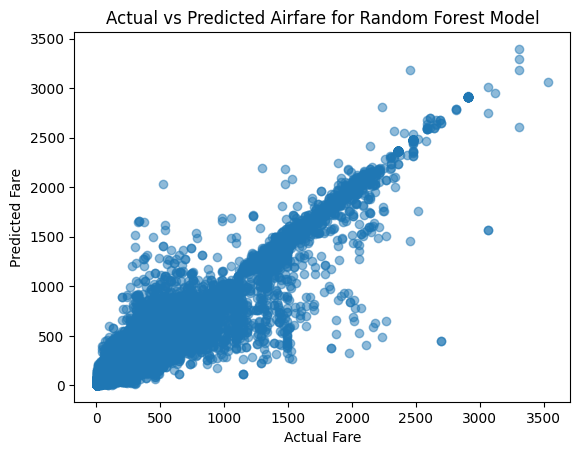

In [ ]:
# Plotting Actual vs Predicted airfares for the Random Forest Model
plt.scatter(y_test_tree, y_pred_randomForest, alpha=0.5)
plt.xlabel("Actual Fare")
plt.ylabel("Predicted Fare")
plt.title("Actual vs Predicted Airfare for Random Forest Model")
plt.show()

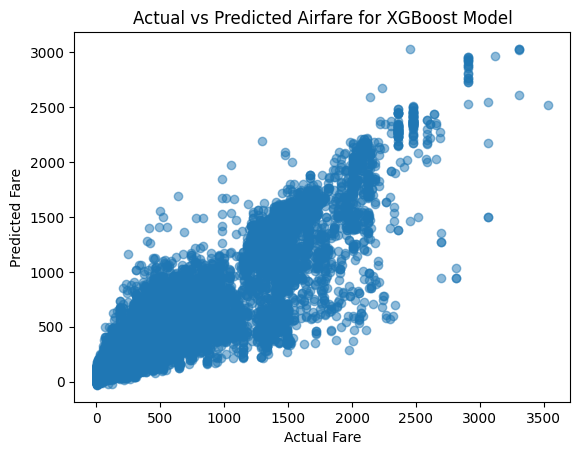

In [ ]:
# Plotting Actual vs Predicted airfares for the XGBoost Model
plt.scatter(y_test_tree, y_pred_xgb, alpha=0.5)
plt.xlabel("Actual Fare")
plt.ylabel("Predicted Fare")
plt.title("Actual vs Predicted Airfare for XGBoost Model")
plt.show()

## Save Model for Web Application Implementation

In [ ]:
# Saving the best-performin model (Random Forest) via pickle
# Used for web application implementation
best_model = randomForest
pickle.dump(best_model, open("flight.pkl",'wb'))